In [145]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.nn.functional import grid_sample
import nibabel as nib
import os
from os.path import join
import numpy as np
import pandas as pd
#from models.densenet import DenseNet
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, confusion_matrix,f1_score, ConfusionMatrixDisplay


In [146]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

#Path to data
path_to_data = "D:\data\dose_matrices_updated_25_01_2023"
print(len(os.listdir(join(path_to_data, "nii"))))

#Config
batch_size = 8

cpu
3939


In [148]:
class CustomDataset(Dataset):
  def __init__(self, annotations_file, path_to_dir, min_card_age, 
               training=False, validation=False, transform=None, target_transform=None):
    
    assert min_card_age == 40 or min_card_age == 50

    self.labels_csv = pd.read_csv(join(path_to_dir, annotations_file), sep=',')

    if training:
      self.img_labels = self.labels_csv[self.labels_csv[f'train_{min_card_age}'] == 1]
    elif validation:
      self.img_labels = self.labels_csv[self.labels_csv[f'val_{min_card_age}'] == 1]

    self.path_to_dir = path_to_dir
    self.img_dir = join(self.path_to_dir, 'nii')

    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):

    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx]["file_name"])
    image = np.squeeze(np.asanyarray(nib.load(img_path).dataobj))
    image_cropped = image[2:66, 3:67, 3:67]

    label = self.img_labels.iloc[idx]['Pathologie_cardiaque_3_new']

    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)

    return image_cropped, label


In [161]:
training_data = CustomDataset("labels.csv", path_to_data, 40, training = True)
val_data = CustomDataset("labels.csv", path_to_data, 40, validation = True)

print(len(training_data), len(val_data))

train_dataloader = DataLoader(training_data, batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_data, batch_size, shuffle=True, drop_last=True)

a, b = next(iter(val_dataloader))
print(b)

# Load NN

#net = DenseNet(num_classes=2)

723 181
tensor([0, 0, 0, 0, 0, 0, 0, 1])


In [164]:
print(f'{training_data.img_labels.Pathologie_cardiaque_3_new.sum()}/{len(training_data)} patients avec une maladie cardiaque dans le training set ({np.around(training_data.img_labels.Pathologie_cardiaque_3_new.mean(), 2)*100} %)')
print(f'{val_data.img_labels.Pathologie_cardiaque_3_new.sum()}/{len(val_data)} patients avec une maladie cardiaque dans le validation set ({np.around(val_data.img_labels.Pathologie_cardiaque_3_new.mean(), 2)*100} %)')

22/723 patients avec une maladie cardiaque dans le training set (3.0 %)
5/181 patients avec une maladie cardiaque dans le validation set (3.0 %)


In [131]:
class Net(nn.Module):
    def __init__(self, batch_size, hidden_units=200):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*64*64, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.fc3 = nn.Linear(hidden_units, 2)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        #x = nn.ReLU()(x)
        #x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.fc3(x)
        return x.float()

In [132]:
model = Net(batch_size)

In [133]:
def test_our_model(val_dataloader, model):  # no arguments, literally all our variable our globals (not great but it's a notebook)
    # Put model in eval mode
    model.eval()  # to remove stuff like dropout that's only going to be in the training part

    # Setup test accuracy value
    test_acc = 0

    # Turn on inference context manager
    with torch.no_grad():
        # Loop through DataLoader batches
        for X_test, y_test in val_dataloader:  # majuscule à X car c'est une "matrice", et y un entier
            # 1. Forward pass
            # print(X_test.view(-1, 64*64*3).shape)
            # break
            #print(X_test.shape)
            #X_flatten = X_test.flatten()
            model_output = model(X_test.float())

            # 2. Calculate and accumulate accuracy
            test_pred_label = model_output.argmax()
            test_acc += (test_pred_label == y_test).sum()  # True == 1, False == 0

    # Adjust metrics to get average loss and accuracy per batch
    test_acc = test_acc / (val_dataloader.batch_size*len(val_dataloader))
    print(test_acc.item())


In [134]:
print("Let's begin")
test_our_model(val_dataloader, model.float())  #ça marche

Let's begin
0.0


In [135]:
loss_fn = nn.CrossEntropyLoss()
optimizer_adam = torch.optim.Adam(params=model.parameters(), lr=0.001)
optimizer_sgd = torch.optim.SGD(model.parameters(), lr=0.1)

nbr_epochs: int = 20

In [136]:
from tqdm import tqdm

In [137]:
print(len(train_dataloader))

24


In [138]:
def train(optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    for epoch in tqdm(range(nbr_epochs)):
        # Loop through data loader data batches
        for i, value in enumerate(train_dataloader):
            if i %100 == 0:
                print(i)

            X, y = value[0], value[1]
            
            # 1. Forward pass
            #X_flatten = X.flatten()
            #X_flatten = X_flatten.float()
            y_pred = model(X.float())

            # 2. Calculate  and accumulate loss
            loss = loss_fn(y_pred.float(), y)
            train_loss += loss.item()

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

            # Calculate and accumulate accuracy metric across all batches
            y_pred_class = y_pred.argmax()
            train_acc += (y_pred_class == y).sum()

        # Adjust metrics to get average loss and accuracy per batch
        train_loss = train_loss / (train_dataloader.batch_size * len(train_dataloader))
        train_acc = train_acc / (train_dataloader.batch_size * len(train_dataloader))
        print(
            f"epoch {epoch+1}/{nbr_epochs},"
            f" train_loss = {train_loss:.2e},"
            f" train_acc = {100*train_acc.item():.2f}%"
        )


In [143]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.float())
        loss = loss_fn(pred, y) #pred.float() ?

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            y_pred_class = pred.argmax()
            train_acc = (y_pred_class == y).sum()
            print(f"loss: {loss:>7f}, accuracy: {train_acc}  [{current:>5d}/{size:>5d}]")


def validation_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    y_val, y_pred = [], []

    with torch.no_grad():
        for X, y in dataloader:
            y_val.extend(y.tolist())
            pred = model(X.float())
            y_pred.extend(pred.argmax(1).tolist())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    print(f"pred = {y_pred}")
    print(f"true = {y_val}")

    

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    scores = {'balanced_accuracy': balanced_accuracy_score(y_val, y_pred),
            'cohen_kappa': cohen_kappa_score(y_val, y_pred),
            'macro_f1': f1_score(y_val, y_pred,average ='macro')}
    print(scores)

    #cm = confusion_matrix(y_true=y_val, y_pred=y_pred)
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    #disp.plot()

Epoch 1
-------------------------------
loss: 0.142602, accuracy: 0  [    0/  194]
pred = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
true = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test Error: 
 Accuracy: 93.9%, Avg loss: 0.323930 

{'balanced_accuracy': 0.48936170212765956, 'cohen_kappa': -0.021276595744680993, 'macro_f1': 0.48936170212765956}



Bad key text.latex.preview in file c:\Users\coust\anaconda3\envs\i2dl\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.6.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file c:\Users\coust\anaconda3\envs\i2dl\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.6.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file c:\Users\coust\anaconda3\envs\i2dl\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default 

Epoch 2
-------------------------------
loss: 0.318090, accuracy: 0  [    0/  194]
pred = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
true = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.347786 

{'balanced_accuracy': 0.5, 'cohen_kappa': 0.0, 'macro_f1': 0.4947368421052632}
Epoch 3
-------------------------------
loss: 0.065128, accuracy: 0  [    0/  194]
pred = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
true = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.271936 

{'balanced_accuracy': 0.5, 'cohen_kappa': 0

KeyboardInterrupt: 

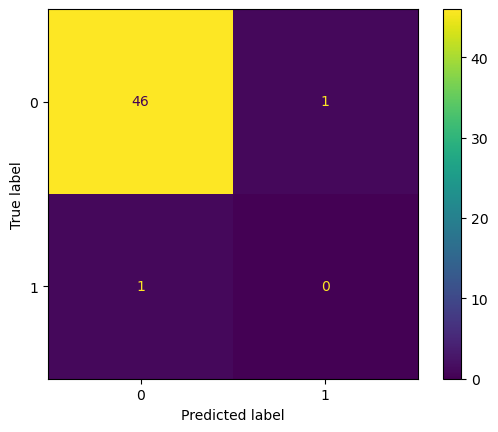

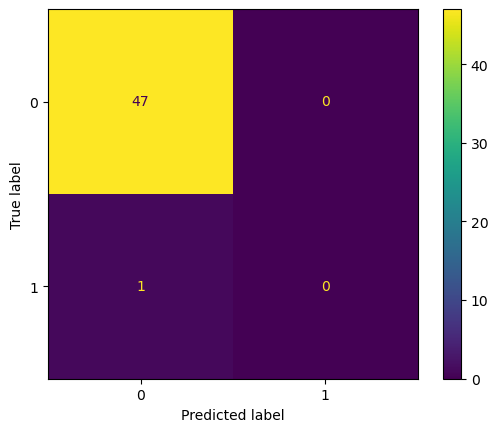

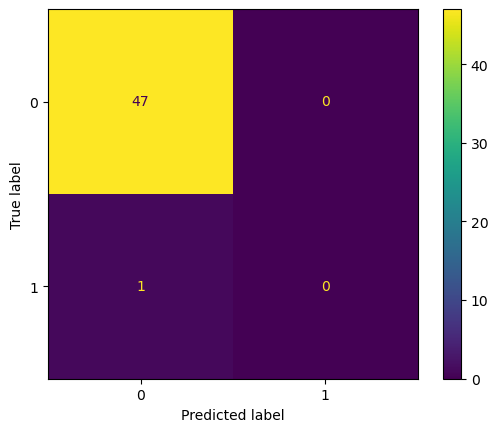

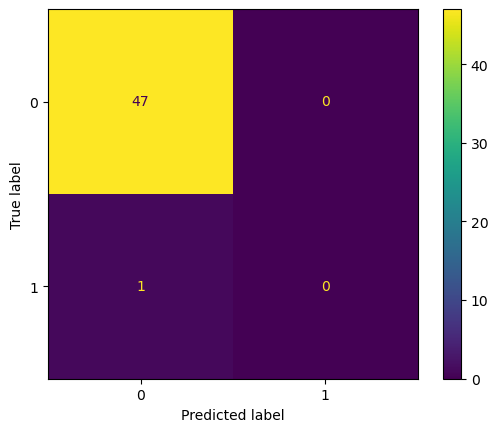

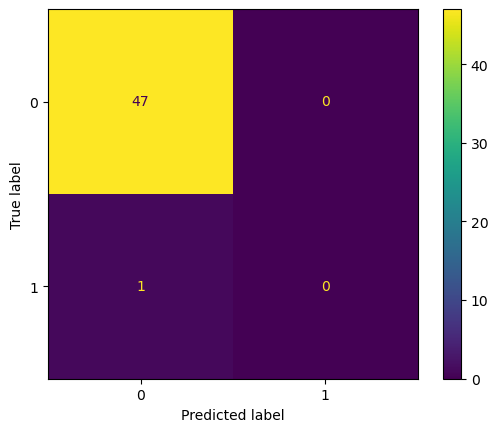

In [144]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    validation_loop(val_dataloader, model, loss_fn)
print("Done!")

In [ ]:
print("Let's check")
test_our_model(val_dataloader, model.float())  #ça marche

Let's check
0.02777777798473835
